# Setup

In [1]:
import math
import numpy as np

from tqdm import tqdm
from glob import glob

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

# 시각화
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

# Network
from net.network import MultiScaleMLPSequential

In [2]:
# CUDA check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


# Pretraining

## Helper function

In [9]:
def compute_derivatives(model, xy_data):
    """
    Get fxx, fyy
    """
    xy_data = xy_data.to(device)
    # Ensure that xy_data has gradient information.
    xy_data.requires_grad_(True)
    
    # Get the model prediction.
    f_pred = model(xy_data)
    
    # Create a tensor of ones with the same shape as f_pred to be used for gradient computation.
    # Reshape the ones tensor to match the shape of f_pred.
    ones = torch.ones(f_pred.shape, device=device, requires_grad=False)
    
    # Compute the first derivatives.
    f_x = torch.autograd.grad(f_pred, xy_data, grad_outputs=ones, create_graph=True)[0][:, 0]
    f_y = torch.autograd.grad(f_pred, xy_data, grad_outputs=ones, create_graph=True)[0][:, 1]
    
    # Compute the second derivatives.
    f_xx = torch.autograd.grad(f_x, xy_data, grad_outputs=ones[:, 0], create_graph=True)[0][:, 0]
    f_yy = torch.autograd.grad(f_y, xy_data, grad_outputs=ones[:, 0], create_graph=True)[0][:, 1]
    
    return f_xx, f_yy

def multiscale_task_loss(model, criterion, xy_daya, f_data, B, C, alpha=0.1):
    """
    추가 도입 예정
    """
    pass


def create_dataloader(data, batch_size, shuffle=True):
    """
    get dataloader
    """
    xy_data = torch.tensor(np.stack([data.T[0], data.T[1]], axis=-1), dtype=torch.float)
    f_data = torch.tensor(data.T[2], dtype=torch.float).view(-1, 1)
    a_data = torch.tensor(data.T[3], dtype=torch.float).view(-1, 1)
    b_data = torch.tensor(data.T[4], dtype=torch.float).view(-1, 1)
    c_data = torch.tensor(data.T[5], dtype=torch.float).view(-1, 1)
    
    dataset = TensorDataset(xy_data, f_data, a_data, b_data, c_data)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return tqdm(loader, desc="Training ", leave=False)


def train_model(model, loader, epochs):
    """
    Implementation func of model training
    """
    
    for epoch in range(epochs):
        model.train()
        batch_loss = 0.0
        batch_data_loss = 0.0  # To record data loss
        batch_pde_loss = 0.0   # To record pde loss

        for batch_xy, batch_f, batch_a, batch_b, batch_c in loader:
            batch_xy = batch_xy.to(device)
            batch_f  = batch_f.to(device)
            batch_a  = batch_a.to(device)
            batch_b  = batch_b.to(device)
            batch_c  = batch_c.to(device)
            
            optimizer.zero_grad()

            # Calculate the losses
            f_pred = model(batch_xy)
            data_loss = criterion(f_pred, batch_f)
            f_xx, f_yy = compute_derivatives(model, batch_xy)
            true_pde = -(batch_b**2+batch_c**2)*f_pred
            pde_loss = criterion(f_xx + f_yy, true_pde.squeeze())

            # Combine the losses
            loss = data_loss + alpha * pde_loss

            # Backpropagate and optimize
            loss.backward()
            optimizer.step()

            # Record losses
            batch_loss += loss.item()
            batch_data_loss += data_loss.item()
            batch_pde_loss += pde_loss.item()

        avg_loss = batch_loss / len(loader)
        avg_data_loss = batch_data_loss / len(loader)
        avg_pde_loss = batch_pde_loss / len(loader)

        # Append the average losses for this epoch to the history
        loss_history.append(avg_loss)
        data_loss_history.append(avg_data_loss)
        pde_loss_history.append(avg_pde_loss)

        scheduler.step() # ReduceLROnPlateau 이면 Loss를 인자로 넣어야함

        # Print the losses every 100 epochs
        if epoch % 5 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch {epoch}/{epochs}, Total Loss: {avg_loss}, Data Loss: {avg_data_loss}, PDE Loss: {avg_pde_loss}, LR: {current_lr}')

    # 손실값 그래프를 그립니다.
    print("total loss : ",loss_history[-1])
    print("DATA  loss : ",data_loss_history[-1])
    print("PDE   loss : ",pde_loss_history[-1])
    plt.semilogy(loss_history, label="Total")
    plt.semilogy(data_loss_history, label="Data")
    plt.semilogy(pde_loss_history, label="PDE")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Epoch vs loss')
    plt.legend()
    plt.show()

def test_inference(model, test_data_path):
    with open(test_data_path, 'rb') as f:
        data = np.load(f,allow_pickle=True)
    x = data.T[0]
    y = data.T[1]
    X = data[:,:2]
    f_true = data.T[2]

    X = torch.tensor(X, dtype=torch.float)
    X = X.to(device)

    with torch.no_grad():
        f_pred = model(X).cpu().numpy().squeeze()

    loss = np.mean(np.sqrt(np.abs(np.square(f_true.reshape(-1))-np.square(f_pred.reshape(-1)))))
    print("Test MSE Loss : ", loss)

    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
    # grid
    xi, yi = np.mgrid[x.min():x.max():500j, y.min():y.max():500j]

    # f_true figure
    rbf = scipy.interpolate.Rbf(x, y, f_true)
    org = rbf(xi, yi)
    img = ax[0].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
    ax[0].scatter(x, y, c=f_true)
    ax[0].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)

    # f_pred figure
    rbf = scipy.interpolate.Rbf(x, y, f_pred)
    org = rbf(xi, yi)
    img = ax[1].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
    ax[1].scatter(x, y, c=f_pred)
    ax[1].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)
    plt.tight_layout()
    plt.show()
    
    return loss

## Implementation

In [16]:
# 하이퍼 파라미터
batch_size = 50000
shuffle = True # 데이터 셔플
epochs = 3000   # 훈련 epoch
alpha= 0.00001      # Total Loss = Data Loss + alpha * PDE Loss

In [17]:
# Data load
with open("./data/trainXYFABC.npy", 'rb') as f:
    data = np.load(f,allow_pickle=True)
f.close()

# Sample data
print(data.shape) #100000 of [x, y, f(x,y), A, B, C]

(100000, 6)


Training :   0%|          | 0/2 [00:00<?, ?it/s]

Train start



Epoch 0/3000, Total Loss: 3.208478093147278, Data Loss: 3.208412528038025, PDE Loss: 6.56586092710495, LR: 0.1999980280595281
Epoch 5/3000, Total Loss: 3.164325714111328, Data Loss: 3.109950065612793, PDE Loss: 5437.568603515625, LR: 0.19992901831679488
Epoch 10/3000, Total Loss: 3.1260759830474854, Data Loss: 3.1055208444595337, PDE Loss: 2055.5068359375, LR: 0.1997614893854864
Epoch 15/3000, Total Loss: 3.1359500885009766, Data Loss: 3.0691128969192505, PDE Loss: 6683.725830078125, LR: 0.1994956065964319
Epoch 20/3000, Total Loss: 3.209933638572693, Data Loss: 3.1137454509735107, PDE Loss: 9618.81982421875, LR: 0.1991316323438437
Epoch 25/3000, Total Loss: 3.171212673187256, Data Loss: 3.0456948280334473, PDE Loss: 12551.78515625, LR: 0.19866992582636603
Epoch 30/3000, Total Loss: 3.2491971254348755, Data Loss: 3.1013556718826294, PDE Loss: 14784.1455078125, LR: 0.19811094269258908
Epoch 35/3000, Total Loss: 3.281109571456909, Data Loss: 3.154565691947937, PDE Loss: 12654.3837890625,

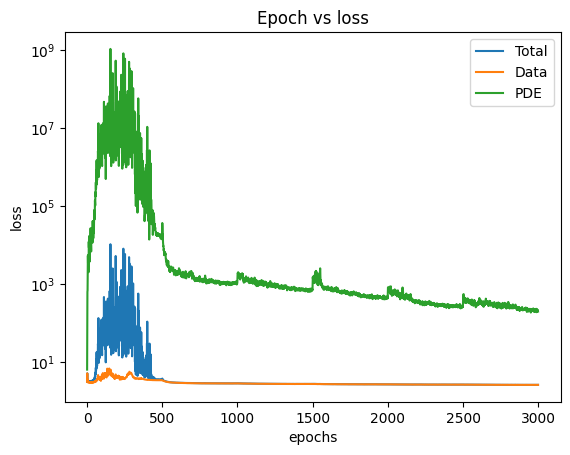

Train end



In [18]:
loader = create_dataloader(data, batch_size, shuffle)

model = MultiScaleMLPSequential(
    in_dim=2,
    out_dim=1,
    layers=7,
    neurons=32,
    residual=True,
    subnets=2,
    base_scale=1.2,
    in_scale= [2*np.pi,2*np.pi],
    in_center=[0, 0],
    vec_scen=2,
    vec_size=12,
)
model = model.to(device)
# loss
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=10, verbose=False)
scheduler = CosineAnnealingWarmRestarts(optimizer, 500, T_mult=1, eta_min=0.0002)

# init
loss_history = []
data_loss_history = []
pde_loss_history = []
best_loss = float('inf')

#### 훈련 시작 ####
print("Train start\n")
train_model(model, loader, epochs)
print("Train end\n")

Test MSE Loss :  3.436957305816465


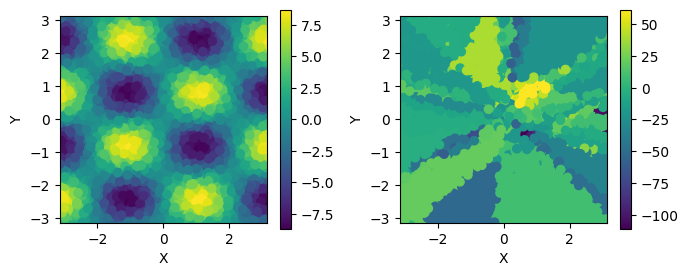

Test MSE Loss :  1.5801800003263542


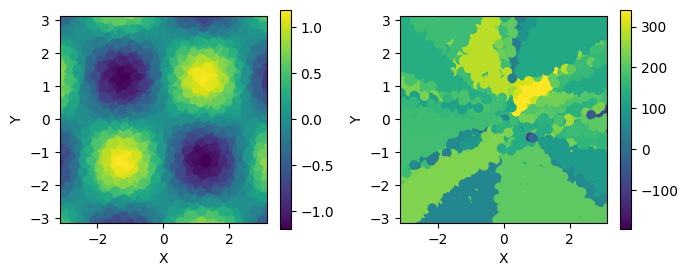

Test MSE Loss :  1.816691677921312


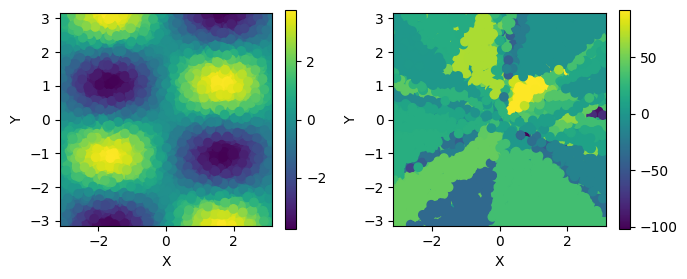

Test MSE Loss :  4.220962573849806


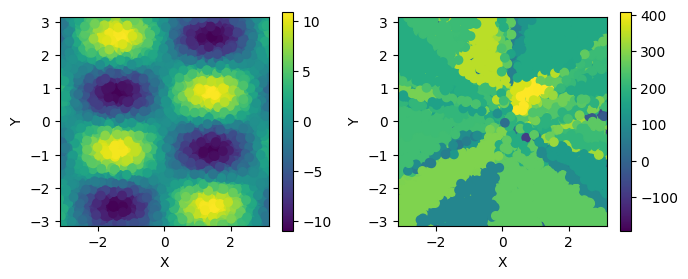

Test MSE Loss :  1.543605363752227


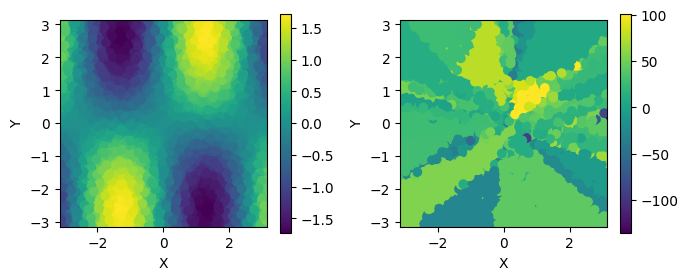

Test MSE Loss :  2.6245100766982343


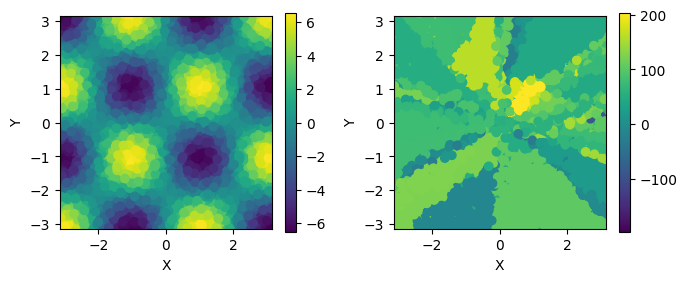

Test MSE Loss :  4.285229336031741


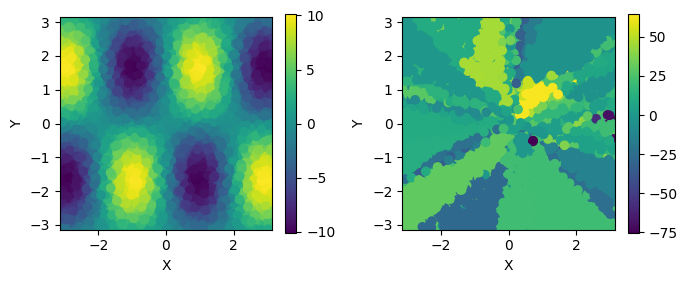

Test MSE Loss :  2.2230648586333026


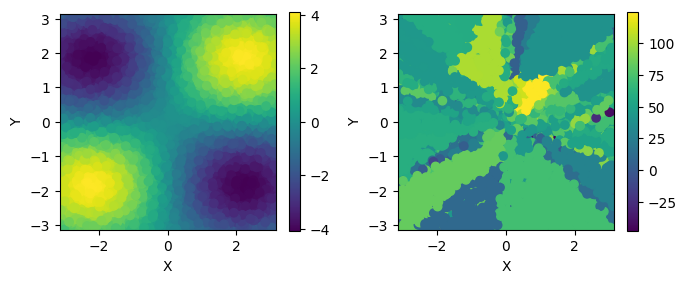

Test MSE Loss :  2.6674352882895764


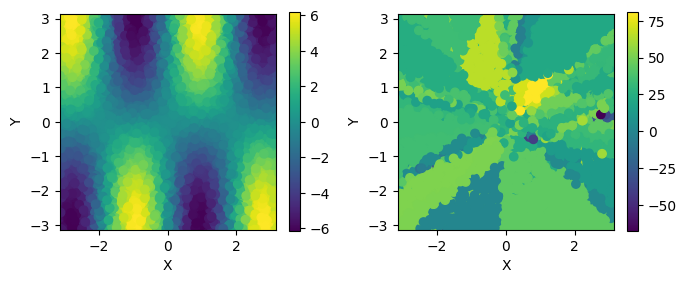

Test MSE Loss :  2.8517948968873874


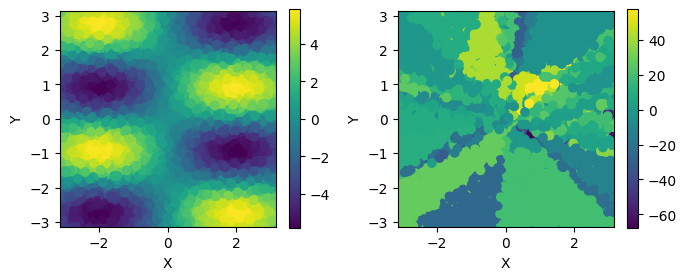

Test MSE Loss :  3.433503750630174


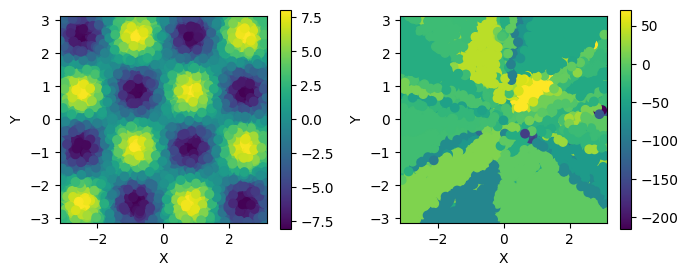

Test MSE Loss :  3.4923350856558923


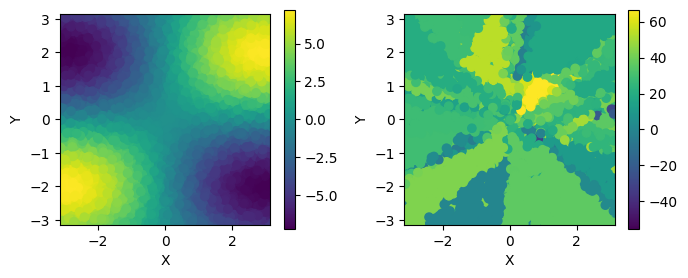

Test MSE Loss :  1.6379877884058454


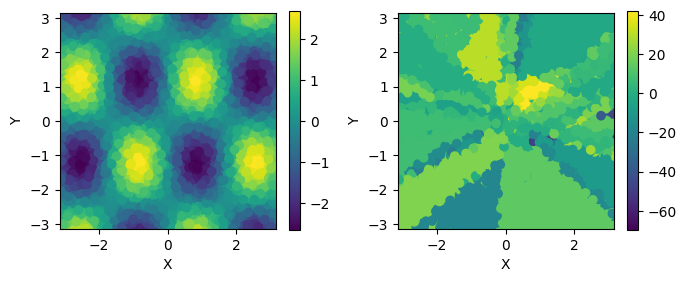

Test MSE Loss :  2.241060611534365


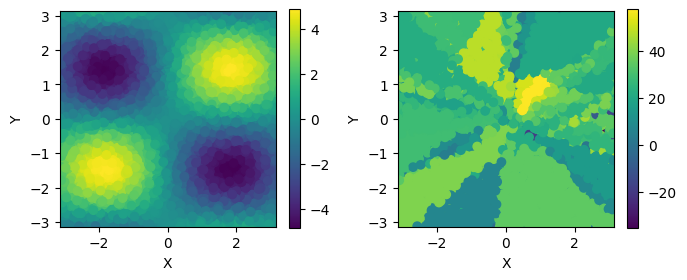

Test MSE Loss :  3.436300338058881


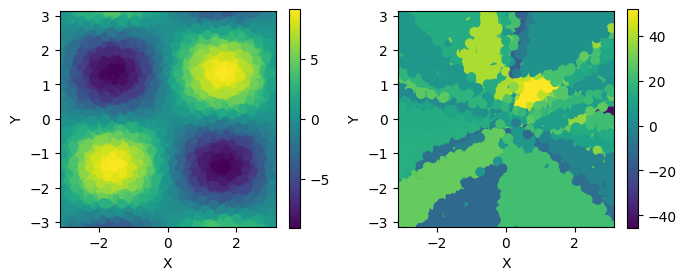

Test MSE Loss :  1.5674409580719901


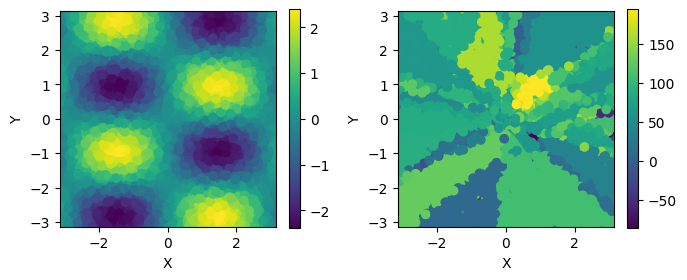

Test MSE Loss :  2.2869221383733622


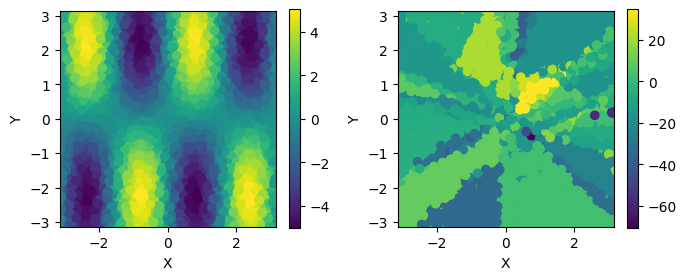

Test MSE Loss :  1.8829214528370133


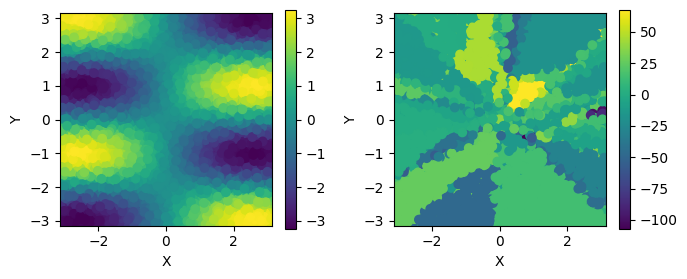

Test MSE Loss :  2.697022290652989


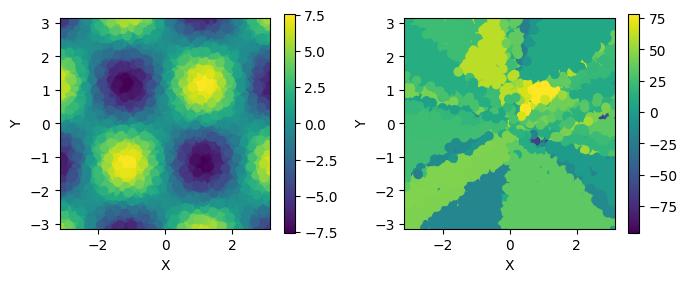

Test MSE Loss :  4.013002490285947


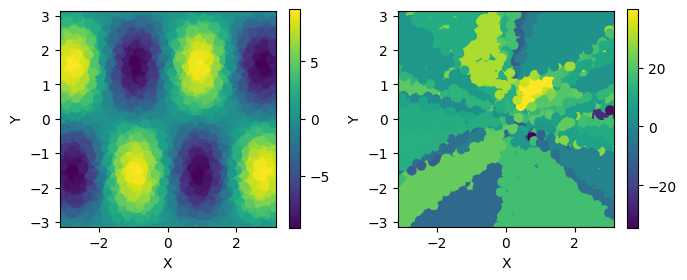

In [20]:
tasks = glob("./data/*_.npy")
for task in tasks:
    test_inference(model, task)

In [14]:
data[:,:2]

array([[ 0.90313922, -1.14623411],
       [ 1.05802157,  0.26567987],
       [-0.00407023,  1.03761888],
       ...,
       [ 2.2816646 , -2.00922591],
       [-1.57845485,  0.17641959],
       [-1.54891844,  0.41061424]])

In [ ]:
def test_inference(model, test_data_path):
    with open(test_data_path, 'rb') as f:
        data = np.load(f,allow_pickle=True)
    x = data.T[0]
    y = data.T[1]
    X = data[:,:2]
    f_true = data.T[2]

    X = torch.tensor(X, dtype=torch.float)
    X = X.to(device)

    with torch.no_grad():
        f_pred = model(X).cpu().numpy().squeeze()

    loss = np.mean(np.sqrt(np.abs(np.square(f_true.reshape(-1))-np.square(f_pred.reshape(-1)))))
    print("Test MSE Loss : ", loss)

    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
    # grid
    xi, yi = np.mgrid[x.min():x.max():500j, y.min():y.max():500j]

    # f_true figure
    rbf = scipy.interpolate.Rbf(x, y, f_true)
    org = rbf(xi, yi)
    img = ax[0].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
    ax[0].scatter(x, y, c=f_true)
    ax[0].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)

    # f_pred figure
    rbf = scipy.interpolate.Rbf(x, y, f_pred)
    org = rbf(xi, yi)
    img = ax[1].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
    ax[1].scatter(x, y, c=f_pred)
    ax[1].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)
    plt.tight_layout()
    plt.show()
    
    return loss

In [7]:
# def piad2d(args):
#     """pretraining and reconstruction process"""
#     config = preprocess_config(args)
#     train_dataset = create_random_dataset(config)
#     train_dataset = train_dataset.create_dataset(batch_size=config["batch_size"], shuffle=True,
#                                                  prebatched_data=True, drop_remainder=True)
#     epoch_steps = len(train_dataset)
#     print("check train dataset size: ", len(train_dataset))
#     # load ckpt
#     if config.get("load_ckpt", False):
#         param_dict = load_checkpoint(config["load_ckpt_path"])
#         if args.mode == "pretrain":
#             loaded_ckpt_dict = param_dict
#         else:
#             loaded_ckpt_dict, latent_vector_ckpt = {}, 0
#             for name in param_dict:
#                 if name == "model.latent_vector":
#                     latent_vector_ckpt = param_dict[name].data.asnumpy()
#                 elif "network" in name and "moment" not in name:
#                     loaded_ckpt_dict[name] = param_dict[name]
#     # initialize latent vector
#     num_scenarios, latent_size = config["num_scenarios"], config["latent_vector_size"]
#     latent_vector = calc_latent_init(latent_size, latent_vector_ckpt, args.mode, num_scenarios)
#     network = MultiScaleFCCell(config["input_size"], config["output_size"],
#                                layers=config["layers"], neurons=config["neurons"], residual=config["residual"],
#                                weight_init=HeUniform(negative_slope=math.sqrt(5)), act="sin",
#                                num_scales=config["num_scales"], amp_factor=config["amp_factor"],
#                                scale_factor=config["scale_factor"], input_scale=config["input_scale"],
#                                input_center=config["input_center"], latent_vector=latent_vector)
#     network = network.to_float(ms.float16)
#     network.input_scale.to_float(ms.float32)
#     mtl_cell = MTLWeightedLossCell(num_losses=train_dataset.num_dataset) if config.get("enable_mtl", True) else None
#     # define problem
#     train_prob = {}
#     for dataset in train_dataset.all_datasets:
#         train_prob[dataset.name] = Maxwell2DMur(network=network, config=config, domain_column=dataset.name + "_points",
#                                                 ic_column=dataset.name + "_points", bc_column=dataset.name + "_points")
#     print("check problem: ", train_prob)
#     train_constraints = Constraints(train_dataset, train_prob)
#     # optimizer
#     params = load_net(args, config, loaded_ckpt_dict, mtl_cell, network)
#     lr_scheduler = MultiStepLR(config["lr"], config["milestones"], config["lr_gamma"], epoch_steps,
#                                config["train_epoch"])
#     optimizer = nn.Adam(params, learning_rate=Tensor(lr_scheduler.get_lr()))
#     # problem solver
#     solver = Solver(network, optimizer=optimizer, mode="PINNs", train_constraints=train_constraints,
#                     test_constraints=None, metrics={'l2': L2(), 'distance': nn.MAE()}, loss_fn='smooth_l1_loss',
#                     loss_scale_manager=DynamicLossScaleManager(), mtl_weighted_cell=mtl_cell,
#                     latent_vector=latent_vector, latent_reg=config["latent_reg"])
#     callbacks = get_callbacks(args, config, epoch_steps, network)
#     solver.train(config["train_epoch"], train_dataset, callbacks=callbacks, dataset_sink_mode=True)